In [2]:
!pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import numpy as np

import findspark
try:
    findspark.init()
except:
    PYSPARK_PATH = '../spark/spark-2.4.3-bin-hadoop2.7/' # change path to yours
    findspark.init(PYSPARK_PATH)
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import *
from pyspark.sql.functions import col, lower, regexp_replace, split, size, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType
from functools import reduce
import re

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

# Get CSV with features

In [104]:
# df_path = "csv_data/top-10-sample-output-ores_features.csv"
# df_path = "csv_data/sample-output-ores_features.csv"
df_path = "../sample_data/csv/enwiki-20190701-features.csv"
df_features = spark.read.csv(df_path, inferSchema=True, header=True, multiLine=True, escape='"')
df_features.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- Stub: double (nullable = true)
 |-- Start: double (nullable = true)
 |-- C: double (nullable = true)
 |-- B: double (nullable = true)
 |-- GA: double (nullable = true)
 |-- FA: double (nullable = true)
 |-- n_words: double (nullable = true)
 |-- n_internal_links: double (nullable = true)
 |-- n_external_links: double (nullable = true)
 |-- level2: double (nullable = true)
 |-- level3: double (nullable = true)
 |-- level4: double (nullable = true)
 |-- level5: double (nullable = true)
 |-- level6: double (nullable = true)
 |-- book_citations: double (nullable = true)
 |-- journal_citations: double (nullable = true)
 |-- web_citations: double (nullable = true)
 |-- news_citations: double (nullable = true)
 |-- average_external_links: double (nullable = true)
 |-- average_internal_links: double (nullable = true)
 |-- n_paragraphs: double (nullable = true)
 |-- n_unreferenced: double (nullable = true)
 |-- n

### Select features for clustering

In [105]:
df_features = df_features.drop('_c0', 'title', 'Stub', 'Start', 'C', 'B', 'GA', 'FA')
features_names = df_features.columns

### Vectorize features for scaling and clustering

In [108]:
vectorAssembler = VectorAssembler(inputCols=features_names,
                                  outputCol="features")

df_features = vectorAssembler.setHandleInvalid("skip").transform(df_features)

# Scaling

In [109]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_features)

# rescale each feature to range [min, max].
scaled_features = scalerModel.transform(df_features)
scaled_features = scaled_features.select('scaled_features')

In [110]:
scaled_features.printSchema()
# scaled_features.limit(20).collect()

root
 |-- scaled_features: vector (nullable = true)



# Clustering K-means

In [111]:
N_CLUSTERS_RANGE = np.arange(3, 6)

In [112]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k_means_costs = []
k_means_models = dict()
for count_clusters in N_CLUSTERS_RANGE:
    kmeans = KMeans(featuresCol='scaled_features').setK(count_clusters).setSeed(1)
    model = kmeans.fit(scaled_features)
    k_means_models[count_clusters] = model
    cost = model.computeCost(scaled_features)
    k_means_costs.append(cost)
    print(f"Clusters: {count_clusters} \t|\t Within Set Sum of Squared Errors = " + str(cost))

Clusters: 3 	|	 Within Set Sum of Squared Errors = 57.04462031091215
Clusters: 4 	|	 Within Set Sum of Squared Errors = 52.48929957730724
Clusters: 5 	|	 Within Set Sum of Squared Errors = 60.17804790192247


In [113]:
bisect_k_means_costs = []
bisect_k_means_models = dict()
for count_clusters in N_CLUSTERS_RANGE:
    bisect_kmeans = BisectingKMeans(featuresCol='scaled_features').setK(count_clusters).setSeed(10)
    model = bisect_kmeans.fit(scaled_features)
    bisect_k_means_models[count_clusters] = model
    cost = model.computeCost(scaled_features)
    bisect_k_means_costs.append(cost)
    print(f"Clussters: {count_clusters} \t|\t Within Set Sum of Squared Errors = " + str(cost))

Clussters: 3 	|	 Within Set Sum of Squared Errors = 57.057749669229814
Clussters: 4 	|	 Within Set Sum of Squared Errors = 52.826278495834465
Clussters: 5 	|	 Within Set Sum of Squared Errors = 49.52971063659668


In [117]:
# predictions = k_means_models[2].transform(scaled_features).select('prediction')

In [148]:
# predictions = k_means_models[2].transform(scaled_features)# .select('prediction')

In [168]:
# predictions.cast("array<int>").dtypes
# qqq

In [167]:
# from pyspark.ml.evaluation import ClusteringEvaluator

# #predictions = bisect_k_means_models[2].transform(scaled_features)
# # predictions = k_means_models[2].transform(scaled_features) # .select('prediction')

# # Evaluate clustering by computing Silhouette score

# predictions = bisect_k_means_models[14].transform(scaled_features).select('prediction')
# vectorAssembler1 = VectorAssembler(inputCols=['prediction'],
#                                   outputCol="prediction_new")

# qqq = vectorAssembler1.setHandleInvalid("skip").transform(predictions)

# evaluator = ClusteringEvaluator(featuresCol='prediction_new')

# silhouette = evaluator.evaluate(qqq)
# print("Silhouette with squared euclidean distance = " + str(silhouette))


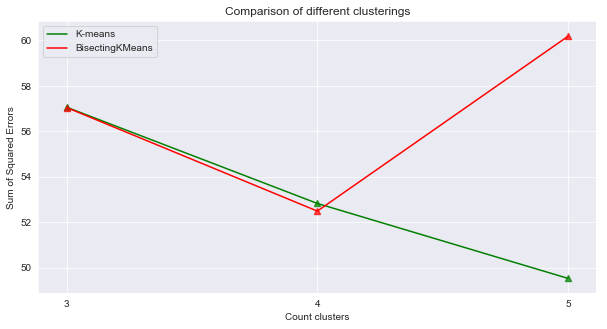

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(N_CLUSTERS_RANGE, bisect_k_means_costs, color='green')
plt.scatter(N_CLUSTERS_RANGE, bisect_k_means_costs, color='green', marker='^', alpha=0.7, linewidths=1.4)

plt.plot(N_CLUSTERS_RANGE, k_means_costs, color='red')
plt.scatter(N_CLUSTERS_RANGE, k_means_costs, color='red', marker='^', alpha=0.7, linewidths=1.4)

plt.xlabel('Count clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Comparison of different clusterings')
plt.legend(['K-means', 'BisectingKMeans'])
plt.xticks(N_CLUSTERS_RANGE)
plt.show()

In [115]:
def get_pca_for_visualise(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    # print(set(labels))

    pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
    model = pca.fit(scaled_features)

    compressed = model.transform(scaled_features).select("pcaFeatures")
    compressed = compressed.toPandas()
    compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
    compressed = compressed.pcaFeatures.values
    compressed = np.stack(compressed, axis=0)

    colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'pink', 4:'orange', 5:'yellow'}
    colors = list(map(lambda x: colors[x], labels))
    return compressed.T, colors

# K-means:

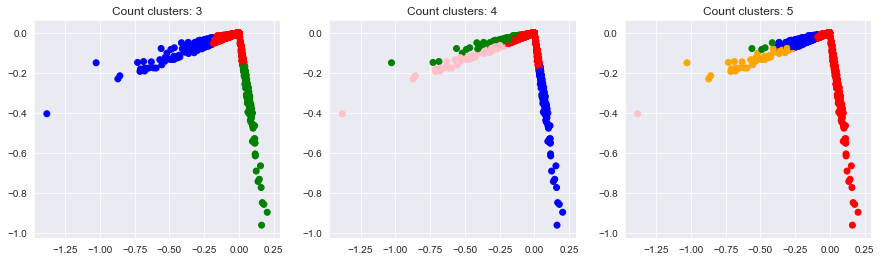

In [116]:
plt.figure(figsize=(15, 4))

N_CLUSTERS_VIS = [3,4,5]
for i, cl in enumerate(N_CLUSTERS_VIS):
    points, colors = get_pca_for_visualise(k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*points, c=colors)
    plt.title('Count clusters: ' + str(cl))

plt.show()

# Bisect K-means:

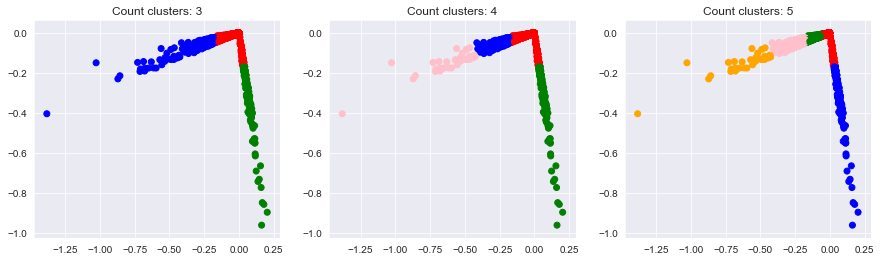

In [117]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    points, colors = get_pca_for_visualise(bisect_k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*points, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

# t-SNE

In [119]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib._color_data as mcd


df_data_for_tsne = df_features.toPandas()[features_names]
embedded_tsne = TSNE(n_components=2).fit_transform(df_data_for_tsne.values)


def colors_for_tsne(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    # colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'pink', 4:'orange', 5:'yellow'}
    colors = dict(zip(range(len(list(mcd.CSS4_COLORS.keys())[20:] )), list(mcd.CSS4_COLORS.keys())[20:] ))
    colors = list(map(lambda x: colors[x], labels))    
    return colors

# K-means on t-SNE

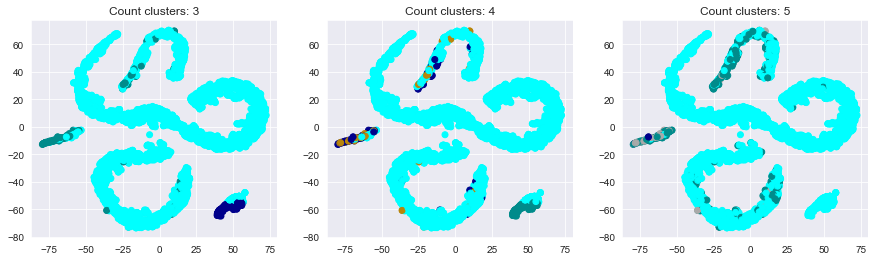

In [122]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    colors = colors_for_tsne(k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*embedded_tsne.T, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

In [ ]:
# plt.figure(figsize=(21,14))

# plt.subplot(2, 3, 1)
# colors = colors_for_tsne(k_means_models[2])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(2))

# plt.subplot(2, 3, 2)
# colors = colors_for_tsne(k_means_models[3])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(3))

# plt.subplot(2, 3, 3)
# colors = colors_for_tsne(k_means_models[4])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(4))

# plt.subplot(2, 3, 4)
# colors = colors_for_tsne(k_means_models[5])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(5))

# plt.subplot(2, 3, 5)
# colors = colors_for_tsne(k_means_models[6])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(6))

# plt.subplot(2, 3, 6)
# colors = colors_for_tsne(k_means_models[7])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(7))

# plt.show()

# Bisect K-means on t-SNE

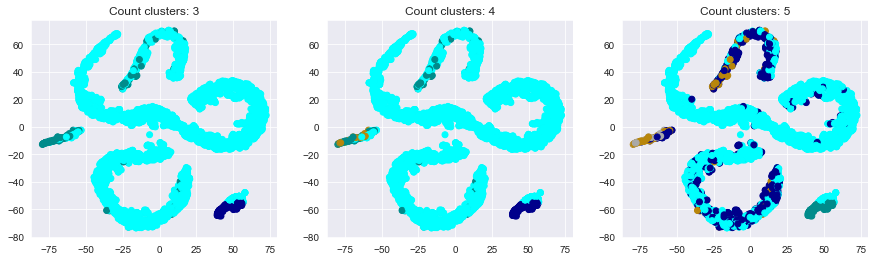

In [124]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    colors = colors_for_tsne(bisect_k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*embedded_tsne.T, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

In [125]:
# plt.figure(figsize=(21,14))

# plt.subplot(2, 3, 1)
# colors = colors_for_tsne(bisect_k_means_models[2])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(2))

# plt.subplot(2, 3, 2)
# colors = colors_for_tsne(bisect_k_means_models[3])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(3))

# plt.subplot(2, 3, 3)
# colors = colors_for_tsne(bisect_k_means_models[4])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(4))

# plt.subplot(2, 3, 4)
# colors = colors_for_tsne(bisect_k_means_models[5])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(5))

# plt.subplot(2, 3, 5)
# colors = colors_for_tsne(bisect_k_means_models[6])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(6))

# plt.subplot(2, 3, 6)
# colors = colors_for_tsne(bisect_k_means_models[7])
# plt.scatter(*embedded_tsne.T, c=colors)
# plt.title('Count clusters: ' + str(7))

# plt.show()

# OUTPUT: 

In [ ]:
k_means_models[3], bisect_k_means_models[3]

In [9]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans(featuresCol='scaled_features').setK(3).setSeed(1)
model = bkm.fit(scaled_features)

# Evaluate clustering.
cost = model.computeCost(scaled_features)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result. 
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 4334.322907773121
Cluster Centers: 
[4.41816342e-03 6.05871560e-02 4.21633284e-01 3.38226916e-01
 1.75860719e-01 1.33750949e-01 1.17404751e-01 6.27008492e-02
 3.01234662e-02 1.36211793e-02 2.09925492e-03 3.30402804e-04
 1.92161040e-02 1.08397259e-02 6.27340914e-02 3.51979696e-02
 9.14101683e-02 5.57199263e-03 3.70502802e-02 5.00000000e-01]
[1.03776352e-01 6.99572954e-01 2.02840145e-01 1.16077459e-01
 1.50231342e-02 5.88593182e-03 1.57850163e-02 2.51075234e-02
 8.53901939e-03 1.17022045e-02 4.14533041e-04 2.28602780e-04
 1.64920577e-03 4.38345830e-04 1.82235869e-02 2.33599902e-03
 1.99008041e-02 2.53795739e-04 1.11765796e-02 5.00000000e-01]
[9.23316569e-01 7.39366382e-02 8.38966812e-03 9.59163034e-03
 1.71153937e-03 1.26769030e-03 1.38980849e-03 2.92297845e-03
 7.12543104e-04 8.96799277e-04 2.08737763e-06 0.00000000e+00
 1.16296754e-04 2.70054481e-05 1.51846050e-03 1.81758052e-04
 2.92170157e-03 2.65182158e-05 1.22808903e-03 5.00000000e-01]


In [10]:
# get predictions and collect into the list
labels = model.transform(scaled_features).select('prediction')
labels = labels.collect() 
# create vanilla list with ints 
# instead of list with element type Rows
labels = list(map(lambda x: x.prediction, labels))

In [11]:
"""
Visualization with PCA
"""
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_features)

compressed = model.transform(df_features).select("pcaFeatures")
compressed.show(10)

+--------------------+
|         pcaFeatures|
+--------------------+
|[19884.2845406643...|
|[2141.58231948718...|
|[10819.1366918810...|
|[5274.36298090202...|
|[3033.26827065264...|
|[1790.08541020889...|
|[4679.62819741169...|
|[4881.89004518290...|
|[3326.15906935333...|
|[865.210217783942...|
+--------------------+
only showing top 10 rows



In [12]:
compressed = compressed.toPandas()
compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
compressed = compressed.pcaFeatures.values
compressed = np.stack(compressed, axis=0)

In [13]:
colors = {0: 'red', 1: 'green', 2: 'blue'}
colors = list(map(lambda x: colors[x], labels))

In [14]:
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

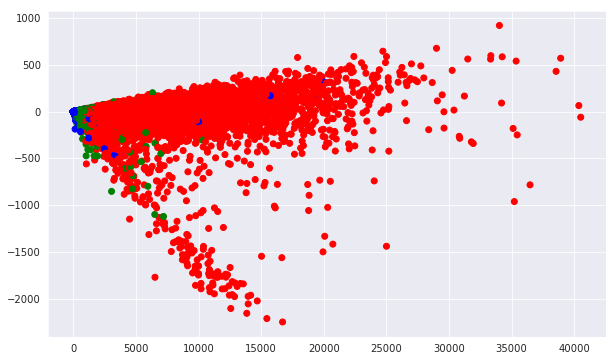

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(*compressed.T, c=colors)